## 
- Reads OLR fields and calculates the daily climatology
- Removes the daily climatology from the OLR to get daily anomalies
- matches up RMM phase with olr anomalies averaged over a domain (Arabian Sea)
- matches up RMM phase with MOV formation
- produces a 3 panel plot
  
### NCSU Tropical and Large Scale Dynamics

- Feb 18, 2023: Code version 1.0  [ A. Aiyyer]
- June 2023: Updated with changes to the histogram with MOV percentages displayed on top of each bar of MJO phase [A. Aiyyer and S. Dhavale]

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob

import pandas as pd
from datetime import datetime
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
minlon =  57.5
maxlon =  75.
minlat =  7.5
maxlat =  22.5

In [3]:
data_dir  = '/glade/scratch/aiyyer/data/olr/'
olr_file  =  'olr.day.mean.nc'
file_path = data_dir+olr_file
ds = xr.open_dataset(file_path)

In [4]:
dateS = '1982-01-01'
dateE = '2021-12-31'

olr = ds.olr.sel(time=slice(dateS,dateE), lat=slice(maxlat,minlat), lon=slice(minlon,maxlon) )

In [5]:
# group the data by day and calculate the long-term mean (LTM) climatology
gb = olr.groupby(olr.time.dt.dayofyear)
clim = gb.mean(dim='time')


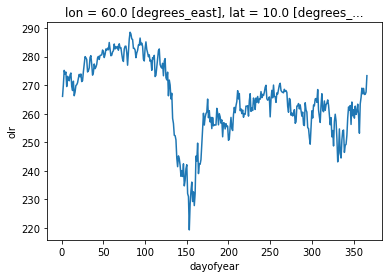

In [6]:
# quick peek at the climatology at a fixed point
clim.sel(lon=60.,lat=10.).plot()

In [7]:
# we will use the xarray rolling construct
# but first we extend the two sides so that rolling mean is effectively
# periodic

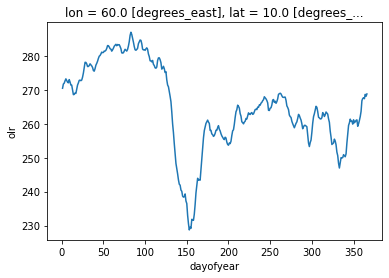

In [8]:
window_days = 2
climP = clim.pad(dayofyear=window_days, mode="wrap")
climS = climP.rolling(dayofyear=window_days*2+1, center=True).mean(skipna=False).dropna(dim='dayofyear')
climS.sel(lon=60.,lat=10.).plot()

### Now remove the climatology to get the anomalies (daily relative to LTM daily)

In [9]:
anom=gb-climS

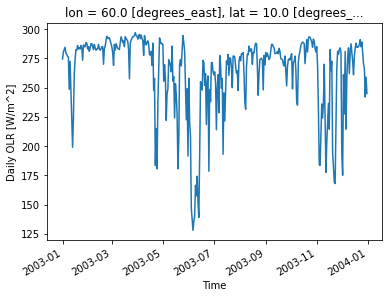

In [10]:
# inspect the daily olr for a given location for a given range of period
dateS = '2003-01-01'
dateE = '2003-12-31'
olr.sel(time=slice(dateS,dateE),lon=60.,lat=10.).plot()

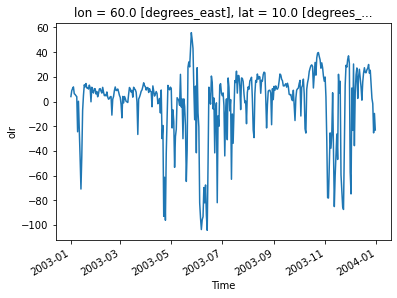

In [11]:
# now plot the olr anomaly for that location
anom.sel(time=slice(dateS,dateE),lon=60.,lat=10.).plot()

In [12]:
# now lets calculate the mean olr within our region of interest


In [13]:
anom_ave = anom.sel(lat=slice(maxlat,minlat), lon=slice(minlon,maxlon)).mean(dim=['lat','lon'])

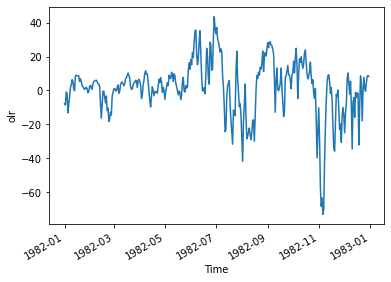

In [14]:
# inspect a year of the area averaged anomalies
dateS = '1982-01-01'
dateE = '1982-12-31'
anom_ave.sel(time=slice(dateS,dateE)).plot()

## Convert the xarray time series of OLR anomaly to a pandas dataframe


In [15]:
AS_olr = anom_ave.to_pandas().reset_index()
AS_olr.columns = ['date', 'OLR']
AS_olr.head()

,date,OLR
0,1982-01-01,-7.872832
1,1982-01-02,-8.538515
2,1982-01-03,-0.952892
3,1982-01-04,-1.686300
4,1982-01-05,-13.234663


In [16]:
import os

cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in %r: %s" % (cwd, files))

Files in '/glade/u/home/sdhavale/MOV_MJO': ['mjo_filtered.nc', 'MJO_phase_days.ipynb', '.ipynb_checkpoints', 'GPI_MOV.ipynb', 'Fig1.ipynb', 'mjo_variance.png', 'MJO_filtered_OLR.ipynb', 'rMII_index_latest.txt', 'mov_mjo_histogram_rmii_phases.png', 'mov_formation_ibtracs_imd_final.ascii', 'mov_mjo_histogram.png', 'GPI_MOV_RMII.ipynb', 'rmm.74toRealtime.txt', 'RMII.ipynb', 'Fig2.ipynb']


## Now We read the rmm index 



In [17]:
rmm_file = 'rmm.74toRealtime.txt'

In [18]:
rmm = pd.read_csv (rmm_file,skiprows=2,header=None,delim_whitespace=True)
rmm.columns = ['year', 'month', 'day', 'RMM1', 'RMM2', 'phase_original', 'amplitude', 'junk']

# combine the year month and day to get a date:
rmm['date'] = pd.to_datetime(rmm[['year', 'month', 'day']])
rmm.drop(columns=['year', 'month', 'day','junk'], inplace=True)

# Now replace the phase corresponding to amplitudes < 1 with phase=0
# Now we have phase=0 for weak MJO events

rmm['phase'] = rmm.phase_original.where(rmm.amplitude>1, 0)

# a quick look at the phases that got replaced
# print(rmm[rmm.phase==0].to_string())
rmm.head()

,RMM1,RMM2,phase_original,amplitude,date,phase
0,1.63447,1.20304,5,2.02948,1974-06-01,5
1,1.60289,1.01512,5,1.89729,1974-06-02,5
2,1.51625,1.08551,5,1.86476,1974-06-03,5
3,1.50981,1.03573,5,1.83092,1974-06-04,5
4,1.55906,1.30518,5,2.03326,1974-06-05,5


## Match the RMM index with the OLR dates

 - Add a column with the RMM phase information in the AS_olr dataframe

In [19]:
AS_olr['rmm_phase'] = rmm[rmm['date'].isin(AS_olr.date)].reset_index().phase
print(AS_olr)



            date        OLR  rmm_phase
0     1982-01-01  -7.872832          1
1     1982-01-02  -8.538515          1
2     1982-01-03  -0.952892          1
3     1982-01-04  -1.686300          1
4     1982-01-05 -13.234663          2
...          ...        ...        ...
14605 2021-12-27   7.622884          7
14606 2021-12-28   6.423859          7
14607 2021-12-29   7.547369          7
14608 2021-12-30   5.158835          7
14609 2021-12-31  -0.872882          7

[14610 rows x 3 columns]


In [20]:
# a quick look at the mean olr anomalies for each phase
#

median_olr = AS_olr.groupby('rmm_phase').median().reset_index()
mean_olr = AS_olr.groupby('rmm_phase').mean().reset_index()

print(mean_olr)
print(median_olr)


   rmm_phase       OLR
0          0  0.738501
1          1 -1.582673
2          2 -6.501942
3          3 -7.376332
4          4 -4.346074
5          5  1.046190
6          6  5.914327
7          7  6.191506
8          8  3.481884
   rmm_phase       OLR
0          0  2.692249
1          1 -0.555934
2          2 -4.224645
3          3 -3.655718
4          4 -0.897729
5          5  3.723244
6          6  6.372707
7          7  6.038525
8          8  4.308307


### Now for more descriptive visualization
# a violinplot

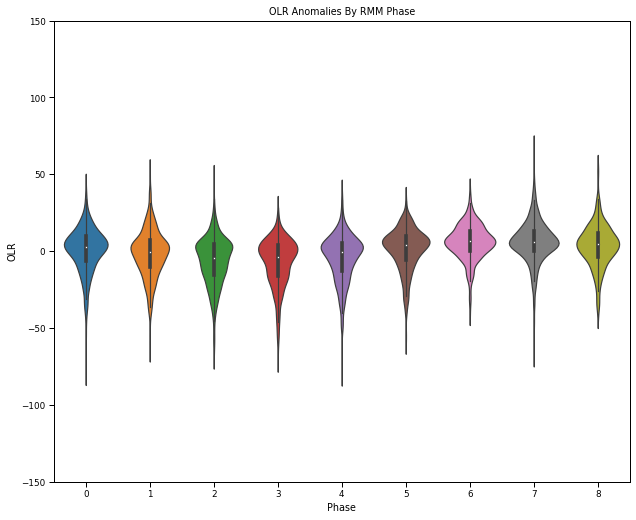

In [21]:
sns.set_context("paper")

fig, ax = plt.subplots(1,figsize=(10,8))

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.5, 
                    hspace=0.5)

#fig.suptitle('')

ax.set(ylim=(-150, 150))

ax = sns.violinplot(data=AS_olr, x='rmm_phase', y='OLR', scale='area')
ax.set_title("OLR Anomalies By RMM Phase")
ax.set_ylabel("OLR")
ax.set_xlabel("Phase")
plt.show()
#p.legend(title='Class', bbox_to_anchor=(1, 1), loc='upper left')


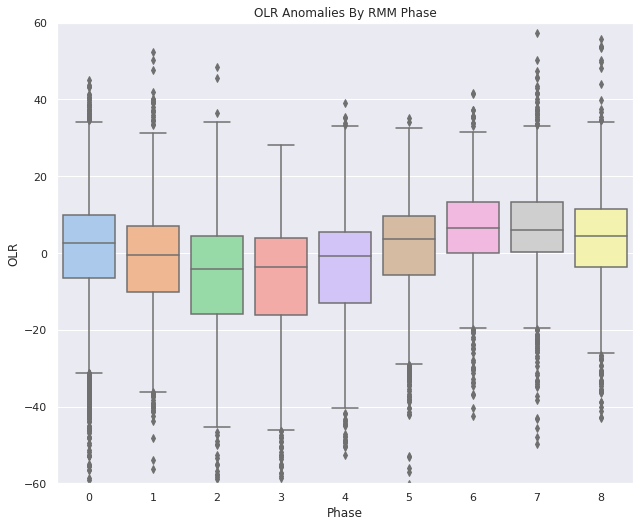

In [22]:
sns.set_context("paper")
sns.set(palette='pastel')
sns.set_context("paper")
sns.set(palette='pastel')
fig, ax = plt.subplots(1,figsize=(10,8))

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.5, 
                    hspace=0.5)

#fig.suptitle('')

ax.set(ylim=(-60, 60))

ax = sns.boxplot(data=AS_olr, x='rmm_phase', y='OLR')
ax.set_title("OLR Anomalies By RMM Phase")
ax.set_ylabel("OLR")
ax.set_xlabel("Phase")
plt.show()
#p.legend(title='Class', bbox_to_anchor=(1, 1), loc='upper left')


In [23]:
#olr_quants = AS_olr.groupby('rmm_phase').OLR.quantile([.5,.75,.90]).reset_index()
#olr_quants.columns = ['Phase','Q','OLR']
#olr_quants.head()

In [24]:
median_olr = AS_olr.groupby('rmm_phase').median().reset_index()
mean_olr = AS_olr.groupby('rmm_phase').mean().reset_index()

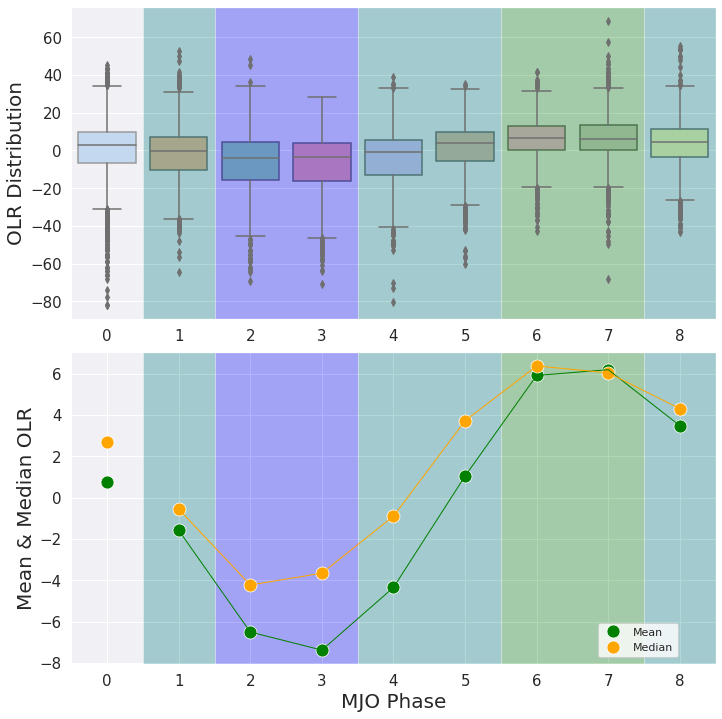

In [25]:
fig, ax = plt.subplots(2, 1,figsize=(10,10))
sns.set_style("whitegrid")

sns.set_palette("pastel")

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1

p1=sns.boxplot(ax=ax[0],data=AS_olr, x='rmm_phase', y='OLR')
p1.set(xlabel=None)  # remove the axis label



X1 = mean_olr['rmm_phase']
Y1 = mean_olr['OLR']
p2=sns.lineplot(ax=ax[1],x=X1, y=Y1,linewidth =0.0,color='green', marker="o", markersize=13)


X2 = median_olr['rmm_phase']
Y2 = median_olr['OLR']
p2=sns.lineplot(ax=ax[1],x=X2, y=Y2,linewidth =0.0,color='orange', marker="o", markersize=13)
ax[1].legend(labels=['Mean','Median'], loc=1, bbox_to_anchor=(0.95, 0.15))



p2=sns.lineplot(ax=ax[1],x=X1[1:], y=Y1[1:],linewidth =1.0,color='green', legend=False)
p2=sns.lineplot(ax=ax[1],x=X2[1:], y=Y2[1:],linewidth =1.0,color='orange',legend=False)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
#p2=sns.lineplot(ax=ax[1],data=mean_olr,x='rmm_phase', y='OLR')


ax[0].set_ylabel("OLR Distribution",fontsize=20)
ax[1].set_ylabel("Mean & Median OLR",fontsize=20)
ax[1].set_xlabel("MJO Phase",fontsize=20)
ax[0].tick_params(labelsize=15)
ax[1].tick_params(labelsize=15)

ax[0].set(xlim=(-.5, 8.5))
ax[1].set(xlim=(-.5, 8.5))


for i in range(0,2):
    ax[i].axvspan(xmin=-1.5, xmax=.5, facecolor =   'white' ,  alpha=0.3)
    ax[i].axvspan(xmin=  .5, xmax=1.5,facecolor =   'teal',  alpha=0.3)
    ax[i].axvspan(xmin=  1.5, xmax=3.5,facecolor =  'blue',  alpha=0.3)
    ax[i].axvspan(xmin=  3.5, xmax=5.5,facecolor =  'teal',  alpha=0.3)
    ax[i].axvspan(xmin=  5.5, xmax=7.5,facecolor =  'green',  alpha=0.3)
    ax[i].axvspan(xmin=  7.5, xmax=8.5,facecolor =  'teal',  alpha=0.3)

plt.show()
#p.legend(title='Class', bbox_to_anchor=(1, 1), loc='upper left')



# Now lets read the MOV formation info

In [26]:
mov_file = 'mov_formation_ibtracs_imd_final.ascii'
mov = pd.read_csv (mov_file,delim_whitespace=True)
mov['date'] = pd.to_datetime(mov['date'], format='%Y%m%d', errors='coerce')

# create a new pandas dataframe that will hold the RMM info for
# the MOV dates: D0,P1,M1  --> day0, day-1, day+1

mov_phase = pd.DataFrame()
mov_phase['phase_D0'] = rmm[rmm['date'].isin(mov.date)].reset_index().phase
mov_phase['date'] = mov['date']


mov_stats = pd.DataFrame()
mov_stats.index = list(range(0,9))
mov_stats['Day 0'] = mov_phase.date.groupby(mov_phase.phase_D0).count()   #.reset_index().date
mov_stats.fillna(0, inplace=True)
mov_stats.index.name = 'Phase'
mov_stats.reset_index(inplace=True)

In [27]:
mov_stats

,Phase,Day 0
0,0,6.0
1,1,4.0
2,2,4.0
3,3,2.0
4,4,3.0
5,5,2.0
6,6,0.0
7,7,0.0
8,8,2.0


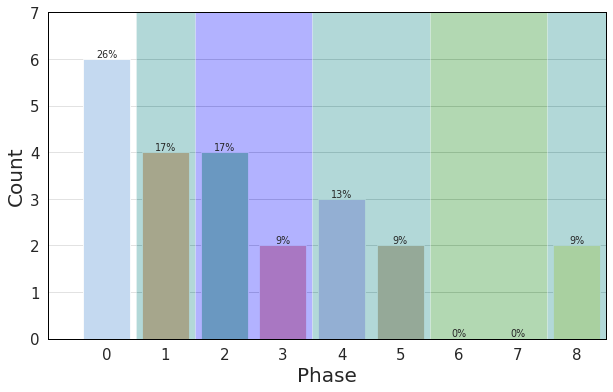

In [38]:
# create a bar chart using seaborn

sns.set_context("paper")
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=mov_stats, x='Phase', y='Day 0')

ax.set(ylim=(0,  7))
ax.set(xlim=(-1, 8.5))

ax.axvspan(xmin=-1.5, xmax=.5, facecolor =   'white' ,  alpha=0.3)
ax.axvspan(xmin=  .5, xmax=1.5,facecolor =   'teal',  alpha=0.3)
ax.axvspan(xmin=  1.5, xmax=3.5,facecolor =  'blue',  alpha=0.3)
ax.axvspan(xmin=  3.5, xmax=5.5,facecolor =  'teal',  alpha=0.3)
ax.axvspan(xmin=  5.5, xmax=7.5,facecolor =  'green',  alpha=0.3)
ax.axvspan(xmin=  7.5, xmax=8.5,facecolor =  'teal',  alpha=0.3)



for icol in range(0,1):
    #perc = (100*mov_stats.iloc[:,icol+1]/(mov_stats.iloc[:,icol+1].sum())).round().apply(np.int64) #.values
    #print(perc.values)
    #ax.bar_label(ax.containers[icol], labels=perc, padding=3)
    perc = (100*mov_stats.iloc[:,icol+1]/(mov_stats.iloc[:,icol+1].sum())).round().apply(np.int64)
    perc = [str(int(p))+"%" for p in perc]
    ax.bar_label(ax.containers[icol], labels=perc)
    
ax.set_xlabel("Phase",fontsize=20)
ax.set_ylabel("Count",fontsize=20)
ax.tick_params(labelsize=15)
plt.show()

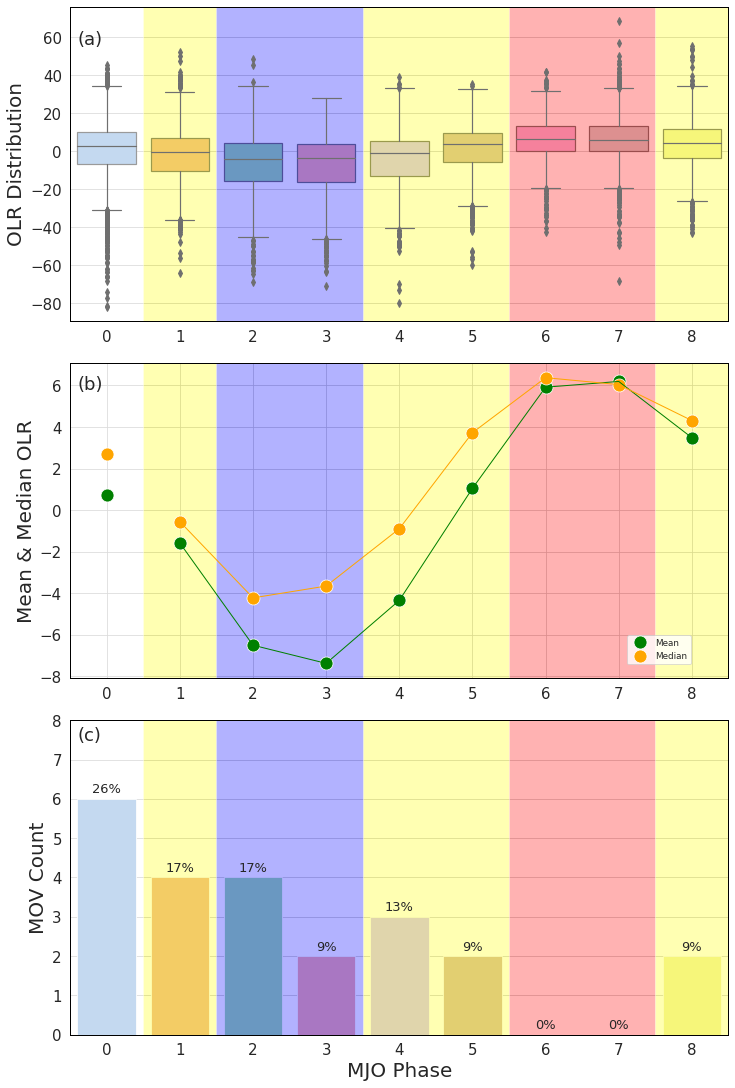

In [39]:
fig, ax = plt.subplots(3, 1,figsize=(10,15))
sns.set_style("whitegrid")

sns.set_palette("pastel")

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1



# Top panel 
p1=sns.boxplot(ax=ax[0],data=AS_olr, x='rmm_phase', y='OLR')
p1.set(xlabel=None)  # remove the axis label


# middle panel
X1 = mean_olr['rmm_phase']
Y1 = mean_olr['OLR']
p2=sns.lineplot(ax=ax[1],x=X1, y=Y1,linewidth =0.0,color='green', marker="o", markersize=13)

X2 = median_olr['rmm_phase']
Y2 = median_olr['OLR']
p2=sns.lineplot(ax=ax[1],x=X2, y=Y2,linewidth =0.0,color='orange', marker="o", markersize=13)
ax[1].legend(labels=['Mean','Median'], loc=1, bbox_to_anchor=(0.95, 0.15))

p2=sns.lineplot(ax=ax[1],x=X1[1:], y=Y1[1:],linewidth =1.0,color='green', legend=False)
p2=sns.lineplot(ax=ax[1],x=X2[1:], y=Y2[1:],linewidth =1.0,color='orange',legend=False)


# bottom panel
p3=sns.barplot(ax=ax[2],data=mov_stats, x='Phase', y='Day 0')



fig.tight_layout()  # otherwise the right y-label is slightly clipped

ax[0].set_ylabel("OLR Distribution",fontsize=20)
ax[1].set_ylabel("Mean & Median OLR",fontsize=20)
ax[2].set_ylabel("MOV Count",fontsize=20)


ax[1].set(xlabel=None)  # remove the axis label
ax[0].set(xlabel=None)  # remove the axis label
ax[2].set_xlabel("MJO Phase",fontsize=20)

ax[2].set(ylim=(0,  8))


for icol in range(0,1):  #really, no need for a loop here since we are only marking day 0 percentages
                         #but i leave it here in case we also plot day-1 and day+1 counts
    perc = (100*mov_stats.iloc[:,icol+1]/(mov_stats.iloc[:,icol+1].sum())).round().apply(np.int64) #.values
    perc = [str(int(p))+"%" for p in perc]
    ax[2].bar_label(ax[2].containers[icol], labels=perc, padding=3, fontsize=13)


ax[0].text(-0.4,56.,'(a)', fontsize=18) #add text
ax[1].text(-0.4,5.8,'(b)', fontsize=18) #add text
ax[2].text(-0.4,7.5,'(c)', fontsize=18) #add text



for i in range(0,3):
    ax[i].axvspan(xmin=-1.5, xmax=.5, facecolor =   'white' ,  alpha=0.3)
    ax[i].axvspan(xmin=  .5, xmax=1.5,facecolor =   'yellow',  alpha=0.3)
    ax[i].axvspan(xmin=  1.5, xmax=3.5,facecolor =  'blue',  alpha=0.3)
    ax[i].axvspan(xmin=  3.5, xmax=5.5,facecolor =  'yellow',  alpha=0.3)
    ax[i].axvspan(xmin=  5.5, xmax=7.5,facecolor =  'red',  alpha=0.3)
    ax[i].axvspan(xmin=  7.5, xmax=8.5,facecolor =  'yellow',  alpha=0.3)
    ax[i].set(xlim=(-.5, 8.5))
    ax[i].tick_params(labelsize=15)

plt.show()
#p.legend(title='Class', bbox_to_anchor=(1, 1), loc='upper left')



# lets get the OLR distributions only for the pre-monsoon dates

In [40]:

year_start = 1982
month_start = 5
day_start   = 10

year_end = 2021
month_end = 6
day_end   = 15


date_series = [pd.date_range(date(i,month_start,day_start),date(i,month_end,day_end), freq ='D') for i in range(year_start,year_end+1)]
# date_series is a list of lists. Lets unpack it now
dates_list = [element for sublist in date_series for element in sublist]

In [41]:
anom_ave_pre_monsoon = anom_ave.sel(time=dates_list)


In [42]:
# convert xarray to pandas 

AS_olr_pre_monsoon = anom_ave_pre_monsoon.to_pandas().reset_index()
AS_olr_pre_monsoon.columns = ['date', 'OLR']

AS_olr_pre_monsoon['rmm_phase'] = rmm[rmm['date'].isin(AS_olr_pre_monsoon.date)].reset_index().phase
print(AS_olr_pre_monsoon)

median_olr_pre_monsoon = AS_olr_pre_monsoon.groupby('rmm_phase').median().reset_index()
mean_olr_pre_monsoon = AS_olr_pre_monsoon.groupby('rmm_phase').mean().reset_index()

           date        OLR  rmm_phase
0    1982-05-10   9.173042          8
1    1982-05-11   5.241223          7
2    1982-05-12   9.816298          7
3    1982-05-13   8.662282          8
4    1982-05-14   4.396017          8
...         ...        ...        ...
1475 2021-06-11  28.950323          0
1476 2021-06-12   9.698477          0
1477 2021-06-13  21.080357          2
1478 2021-06-14  20.111563          2
1479 2021-06-15  17.456522          2

[1480 rows x 3 columns]


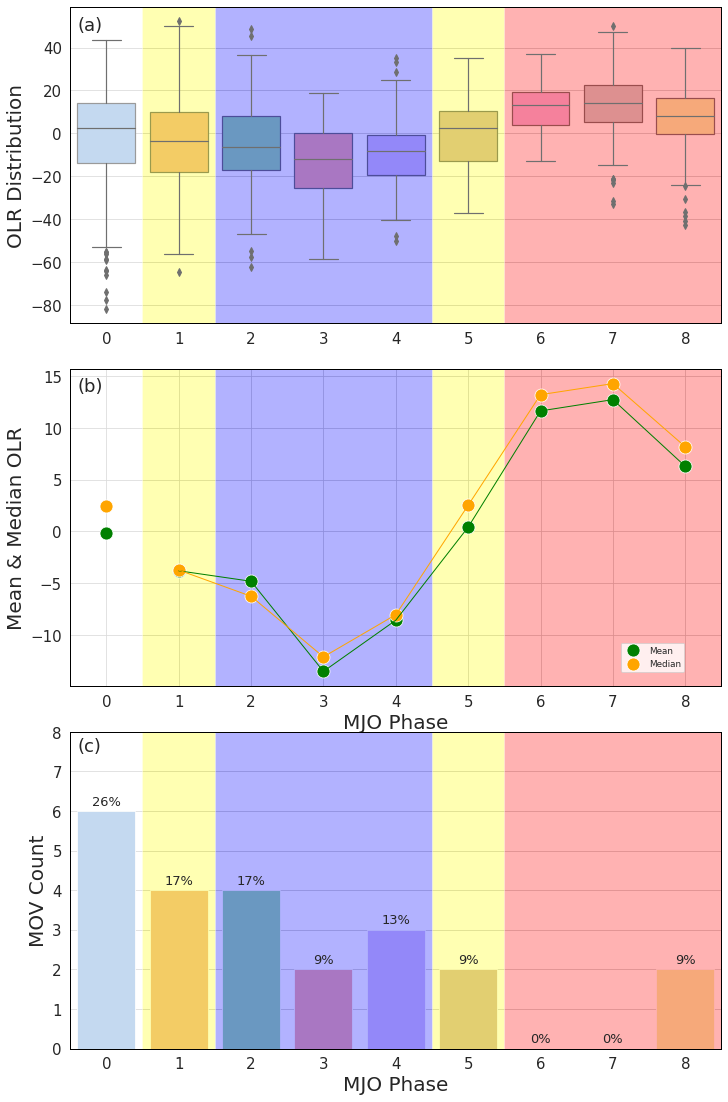

In [43]:
fig, ax = plt.subplots(3, 1,figsize=(10,15))
sns.set_style("whitegrid")

sns.set_palette("pastel")

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1



# top panel
p1=sns.boxplot(ax=ax[0],data=AS_olr_pre_monsoon, x='rmm_phase', y='OLR')
p1.set(xlabel=None)  # remove the axis label



X1 = mean_olr_pre_monsoon['rmm_phase']
Y1 = mean_olr_pre_monsoon['OLR']
p2=sns.lineplot(ax=ax[1],x=X1, y=Y1,linewidth =0.0,color='green', marker="o", markersize=13)


X2 = median_olr_pre_monsoon['rmm_phase']
Y2 = median_olr_pre_monsoon['OLR']
p2=sns.lineplot(ax=ax[1],x=X2, y=Y2,linewidth =0.0,color='orange', marker="o", markersize=13)
ax[1].legend(labels=['Mean','Median'], loc=1, bbox_to_anchor=(0.95, 0.15))



p2=sns.lineplot(ax=ax[1],x=X1[1:], y=Y1[1:],linewidth =1.0,color='green', legend=False)
p2=sns.lineplot(ax=ax[1],x=X2[1:], y=Y2[1:],linewidth =1.0,color='orange',legend=False)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
#p2=sns.lineplot(ax=ax[1],data=mean_olr,x='rmm_phase', y='OLR')


# bottom panel
p3=sns.barplot(ax=ax[2],data=mov_stats, x='Phase', y='Day 0')






ax[0].set_ylabel("OLR Distribution",fontsize=20)
ax[1].set_ylabel("Mean & Median OLR",fontsize=20)
ax[1].set_xlabel("MJO Phase",fontsize=20)
ax[0].tick_params(labelsize=15)
ax[1].tick_params(labelsize=15)
ax[2].tick_params(labelsize=15)

ax[0].set(xlim=(-.5, 8.5))
ax[1].set(xlim=(-.5, 8.5))
ax[2].set(xlim=(-.5, 8.5))

ax[2].set_ylabel("MOV Count",fontsize=20)
ax[2].set_xlabel("MJO Phase",fontsize=20)
ax[2].set(ylim=(0,  8))



for icol in range(0,1):  #really, no need for a loop here since we are only marking day 0 percentages
                         #but i leave it here in case we also plot day-1 and day+1 counts
    perc = (100*mov_stats.iloc[:,icol+1]/(mov_stats.iloc[:,icol+1].sum())).round().apply(np.int64) #.values
    perc = [str(int(p))+"%" for p in perc]
    ax[2].bar_label(ax[2].containers[icol], labels=perc, padding=3, fontsize=13)


ax[0].text(-0.4,48.,'(a)', fontsize=18) #add text
ax[1].text(-0.4,13.5,'(b)', fontsize=18) #add text
ax[2].text(-0.4,7.5,'(c)', fontsize=18) #add text


for i in range(0,3):
    ax[i].axvspan(xmin=-1.5, xmax=.5, facecolor =   'white' ,  alpha=0.3)
    ax[i].axvspan(xmin=  .5, xmax=1.5,facecolor =   'yellow',  alpha=0.3)
    ax[i].axvspan(xmin=  1.5, xmax=4.5,facecolor =  'blue',  alpha=0.3)
    ax[i].axvspan(xmin=  4.5, xmax=5.5,facecolor =  'yellow',  alpha=0.3)
    ax[i].axvspan(xmin=  5.5, xmax=8.5,facecolor =  'red',  alpha=0.3)
   # ax[i].axvspan(xmin=  7.5, xmax=8.5,facecolor =  'yellow',  alpha=0.3)

#plt.show()
#p.legend(title='Class', bbox_to_anchor=(1, 1), loc='upper left')

plt.savefig("mov_mjo_histogram.png")